In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scsavailability as scs
    
import statsmodels.api as sm
from scipy import stats

from scsavailability import features as feat, model as md, plotting as pt, score as sc

2020-12-15 10:38:21,278 - NumExpr defaulting to 8 threads.


In [2]:
path = '../raw_data/'

In [3]:
at = pd.read_csv(path+'active_totes_20201123.csv')
av = pd.read_csv(path+'Availability_with_Grey&Blue_1811-2511.csv')
#fa = pd.read_csv(path + 'scs_tote_matched.csv')
scs_raw = pd.read_csv('../raw_data/SCS alerts Nov.csv')

In [4]:
fa = feat.add_code(scs_raw)
fa, unmapped = feat.add_tote_colour(fa)

Running: Function "load_tote_lookup" (id=3037260401392) was called 1 times


In [5]:
at = feat.pre_process_AT(at)

Running: Function "pre_process_AT" (id=3037260400240) was called 1 times


In [6]:
av = feat.pre_process_av(av)

Running: Function "pre_process_av" (id=3037260401104) was called 1 times


In [7]:
fa = feat.preprocess_faults(fa,remove_same_location_faults = True)

Running: Function "preprocess_faults" (id=3037260402256) was called 1 times
Running: Function "load_module_lookup" (id=3037260399520) was called 1 times
duplicated location faults removed - max duration kept


In [8]:
fa_floor = feat.floor_shift_time_fa(fa, shift=0)

Time shifted by 0Minutes


In [9]:
fa_sel = feat.fault_select(fa_floor, fault_select_options = {'Tote Colour':['Blue']})
                                                            
fa_agg = feat.faults_aggregate(fa_sel, fault_agg_level= None, agg_type = 'count')

Running: Function "faults_aggregate" (id=3037260400816) was called 1 times


In [10]:
av_sel,at_sel = feat.av_at_select(av, at, remove_high_AT = True,availability_select_options = None)

av_agg = feat.aggregate_availability(av_sel, agg_level = None)
at_agg = feat.aggregate_totes(at_sel, agg_level = None)

Running: Function "aggregate_availability" (id=3037260400960) was called 1 times


In [11]:
av_agg.columns

Index(['Downtime', 'Blue Tote Loss', 'Grey Tote Loss'], dtype='object')

In [12]:
df = feat.merge_av_fa_at(av_agg ,at_df=at_agg, fa_df = fa_agg, target = 'Blue Tote Loss' ,faults=True, totes = True, agg_level = None,remove_0=True)

Datasets merged


In [13]:
X,y = md.gen_feat_var(df)
y=1-y

In [14]:
X_train, X_test, y_train, y_test = md.split(X,y)

#RF_mdl,predictions_RF=md.run_RF_model(X_train, X_test, y_train, y_test,num_trees=100, criterion = 'mse', max_depth=None, dtree=False)

Linear_mdl,predictions_LM,Coeff,fit_metrics = md.run_LR_model(X_train, X_test, y_train, y_test)

XGB_mdl,predictions_XGB,Importance_XGB = md.run_XGB_model(X_train, X_test, y_train, y_test)

maxf = None

# X_sel_rf = md.select_features(X, y, RF_mdl, thres = -np.inf, max_feat = maxf)

X_sel_lm = md.select_features(X, y, Linear_mdl, selection_options={'thres': 'mean', 'max_feat': None})

X_sel_XGB = md.select_features(X, y, XGB_mdl, selection_options={'thres': 'mean', 'max_feat': None})

#X_train, X_test, y_train, y_test = md.split(X_sel_lm,y,test_size=0.3,random_state=101)

#Linear_mdl,predictions_LM,Coeff,fit_metrics = md.run_LR_model(X_train, X_test, y_train, y_test)


cv_R2 = md.cross_validate_r2(Linear_mdl, X_sel_lm, y, n_folds = 10, shuffle = True, random_state = 101)

#cv_R2 = md.cross_validate_r2(RF_mdl, X_sel_rf, y, n_folds = 10, shuffle = True, random_state = 101)

cv_R2 = md.cross_validate_r2(XGB_mdl, X_sel_XGB, y, n_folds = 10, shuffle = True, random_state = 101)

#md.stats_model(Linear_mdl,X_test,y_test)

Feature Importance Ranking: 
 
    Importance       Feature
0     0.93916         TOTES
1     0.06084  Total Faults

Regression Metrics: 
 
          XGB Metrics
MAE         0.039359
MSE       0.00264334
RMSE       0.0514134
MAPE%           5.16
ACC%           94.84
OOB              N/A
R2_Train    0.999825
R2_Pred     0.606715 


Number of Selected Features:1 


Number of Selected Features:1 


Cross Validation Scores LinearRegression(): 
 
        R2 Scores
1       0.505582
2       0.777573
3       0.659544
4       0.376290
5       0.893787
6       0.517489
7       0.870516
8       0.850289
9       0.881829
10      0.614691
Mean    0.694759
STD     0.176871

Cross Validation Scores XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=

### Add LM - metrics

In [15]:
sc.lm_coefficients(Linear_mdl, X, y)

,Feature,Coefficients,Standard Errors,t values,Probabilities
0,Constant,0.2555,0.028,9.184,0.000
1,Total Faults,0.0005,0.000,2.799,0.006
2,TOTES,0.0098,0.000,22.285,0.000


In [16]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train,X_train)
results = model.fit()
print(results.summary())

X_new = sm.add_constant(X_test)
#y_prediction =  results.predict(X_test)

# plt.scatter(y_prediction,y_test)

# from sklearn.metrics import r2_score
# print(r2_score(y_prediction,y_test))

                            OLS Regression Results                            
Dep. Variable:         Blue Tote Loss   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     186.3
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           7.89e-31
Time:                        10:39:13   Log-Likelihood:                 130.87
No. Observations:                  83   AIC:                            -255.7
Df Residuals:                      80   BIC:                            -248.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2555      0.032      7.949   

In [17]:
# plt.figure(figsize=(20,5))
# sns.barplot(data=Coeff, x='Feature',y = 'Coefficients')

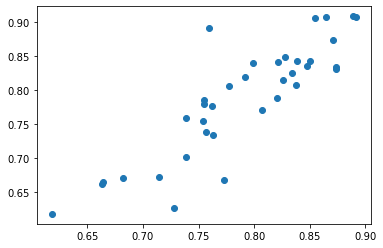

In [18]:
plt.scatter(predictions_LM,y_test)